In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2, os
import tensorflow as tf
from tensorflow.keras import  layers, models
from sklearn.model_selection import train_test_split
from PIL import Image, ImageCms

In [2]:
def set_seed(seed=2137):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()
DATA_PATH = 'data/landscape/'
IMG_DIM =(224,224)

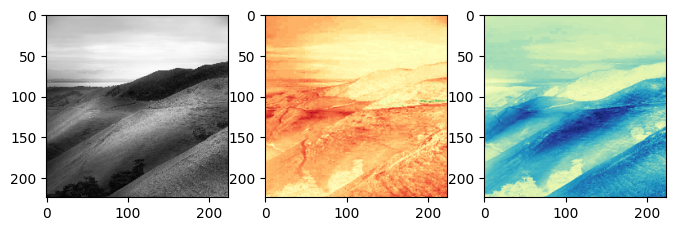

In [3]:
img_test = cv2.imread(DATA_PATH + '00000000.jpg')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2LAB)
img_test = cv2.resize(img_test,IMG_DIM)
plt.figure(figsize=(8,8))
ax = plt.subplot(1,3,1)
plt.imshow(img_test[:,:,0],cmap='gray')
ax = plt.subplot(1,3,2)
plt.imshow(img_test[:,:,1],cmap='RdYlGn')
ax = plt.subplot(1,3,3)
plt.imshow(img_test[:,:,2],cmap='YlGnBu')



In [4]:
X = []
y = []
for imgdir in os.listdir(DATA_PATH):
    img = cv2.imread(DATA_PATH + imgdir)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_lab_rs = cv2.resize(img_lab,IMG_DIM)
    img_l = img_lab_rs[:,:,0]
    img_ab = img_lab_rs[:,:,1:] 
    X.append(img_l[...,np.newaxis]) # [...,np.newaxis] sprawia że mamy tensor (128,128,1) a nie (128,128)
    y.append(img_ab)
    
X = np.array(X)
y = np.array(y)
X = X /255
y = y / 128 -1 

    

In [5]:
X_train,X_test, y_train,y_test = train_test_split(X, y,test_size=0.2)
input_shape = X_train[0].shape
print(input_shape)

(224, 224, 1)


In [6]:
model = tf.keras.Sequential([
    layers.InputLayer(shape=input_shape),

    
  layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    
    # Decoder
    layers.Conv2DTranspose(64, (4, 4), strides=2, activation='relu', padding='same', kernel_initializer='he_uniform'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    
    layers.Conv2DTranspose(32, (4, 4), strides=2, activation='relu', padding='same', kernel_initializer='he_uniform'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    
    layers.Conv2D(2, (3, 3), activation='tanh', padding='same', kernel_initializer='he_uniform'),
])

In [7]:

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 112, 112, 64)        │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 224, 224, 32)        │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 2)         │             578 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 470,850 (1.80 MB)

 Trainable params: 470,274 (1.79 MB)

 Non-trainable params: 576 (2.25 KB)

In [8]:
def augment_data(img_l,img_ab):
    image=tf.concat([img_l,img_ab],axis=-1)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    
    image_l = image[..., :1]
    image_ab = image[..., 1:]

    return image_l, image_ab
def create_dataset(X,y,batch_size=32, augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(1000)
    if augmentation:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset
    
    

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]


In [10]:
train_ds = create_dataset(X_train, y_train, batch_size=32, augmentation=True)
val_ds = create_dataset(X_test, y_test, batch_size=32, augmentation=False)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=callbacks,
                   verbose=1)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - loss: 0.0968 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - loss: 0.0170 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - loss: 0.0147 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - loss: 0.0136 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - loss: 0.0134 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - loss: 0.0138 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - loss: 0.0134 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - loss: 0.0133 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - loss: 0.0133 - val_loss: 0.0146 - learning_rate: 0.0010
E

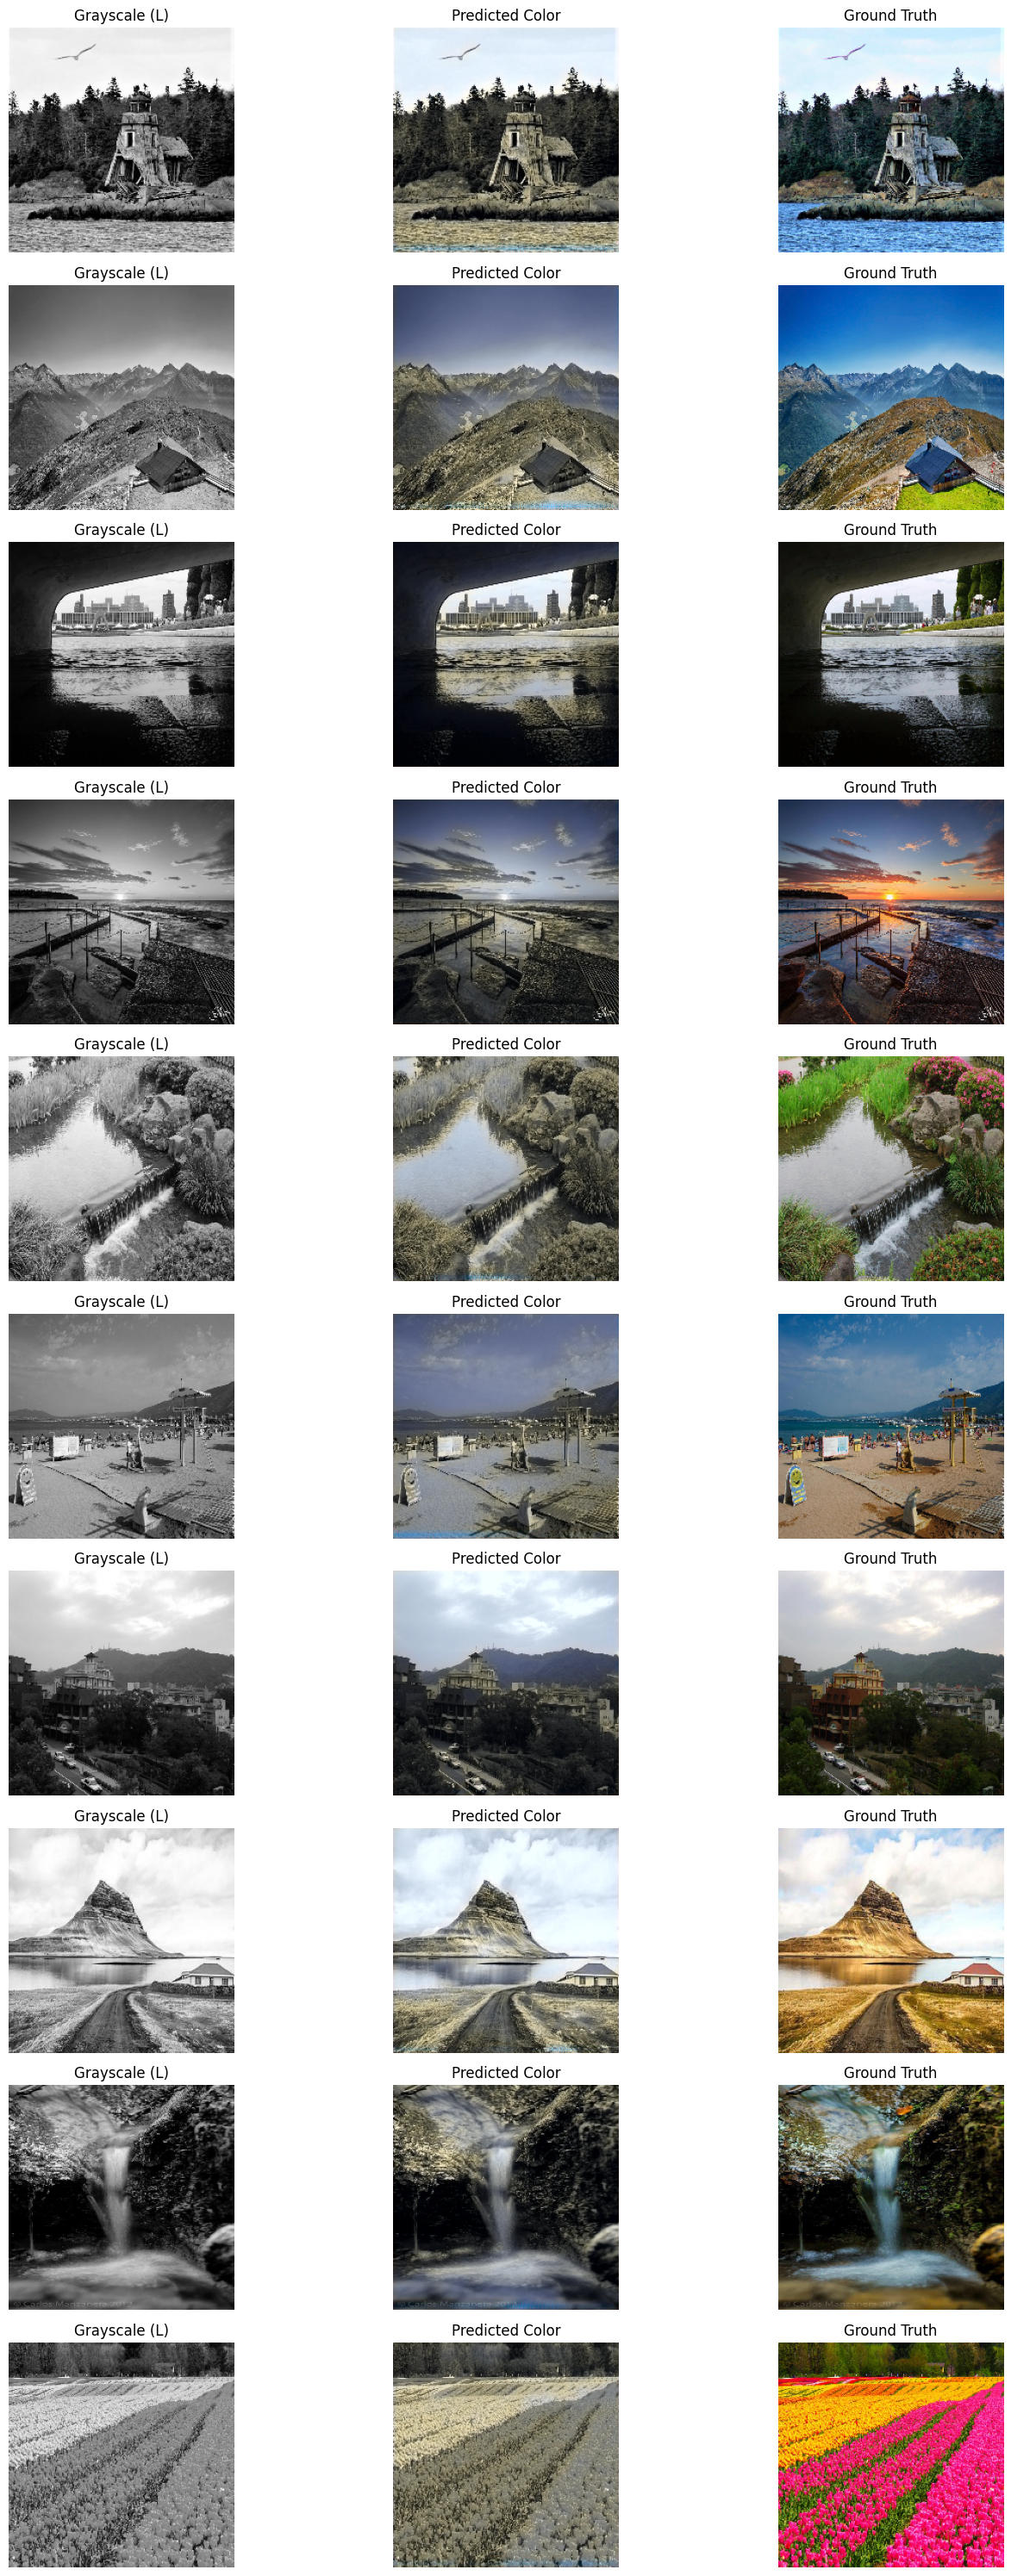

TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

<Figure size 640x480 with 0 Axes>

In [12]:
def display_colorized_images(model, X_test, y_test=None, num_images=10):
    indices = np.random.choice(len(X_test), num_images, replace=False)
    plt.figure(figsize=(15, num_images * 3)) 
    
    for i, idx in enumerate(indices):
        img_l = X_test[idx][np.newaxis, ...]  
        img_l_display = img_l[0, ..., 0] * 255  
        
        
        pred_ab = model.predict(img_l, verbose=0)[0] 
        pred_ab = (pred_ab + 1) * 128 
        
        
        img_lab = np.zeros((224, 224, 3), dtype=np.float32)
        img_lab[:, :, 0] = img_l_display
        img_lab[:, :, 1:] = pred_ab
        
        
        img_rgb = cv2.cvtColor(img_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
        
        
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.title("Grayscale (L)")
        plt.imshow(img_l_display, cmap='gray')
        plt.axis('off')
        
        
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.title("Predicted Color")
        plt.imshow(img_rgb)
        plt.axis('off')
        
        
        if y_test is not None:
            img_ab_true = (y_test[idx] + 1) * 128  
            img_lab_true = np.zeros((224, 224, 3), dtype=np.float32)
            img_lab_true[:, :, 0] = img_l_display
            img_lab_true[:, :, 1:] = img_ab_true
            img_rgb_true = cv2.cvtColor(img_lab_true.astype(np.uint8), cv2.COLOR_LAB2RGB)
            
            plt.subplot(num_images, 3, i * 3 + 3)
            plt.title("Ground Truth")
            plt.imshow(img_rgb_true)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()


display_colorized_images(model, X_test, y_test, num_images=10)
plt.savefig()

In [13]:
output_dir = "colorization_results"
os.makedirs(output_dir, exist_ok=True)

def save_colorized_images(model, X_test, y_test=None, num_images=10, epoch=None):
    # Wybierz losowo 10 indeksów z zestawu testowego
    indices = np.random.choice(len(X_test), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        # Przygotuj obraz L (skala szarości)
        img_l = X_test[idx][np.newaxis, ...]  # Dodaj wymiar batch
        img_l_display = img_l[0, ..., 0] * 255  # Denormalizacja do [0, 255]
        
        # Predykcja kanałów a/b
        pred_ab = model.predict(img_l, verbose=0)[0]  # Predykcja
        pred_ab = (pred_ab + 1) * 128  # Denormalizacja z [-1, 1] do [0, 255]
        
        # Połącz kanały L, a, b w obraz LAB
        img_lab = np.zeros((224, 224, 3), dtype=np.float32)
        img_lab[:, :, 0] = img_l_display
        img_lab[:, :, 1:] = pred_ab
        
        # Konwersja z LAB do RGB
        img_rgb = cv2.cvtColor(img_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
        
        # Zapisz obraz w skali szarości
        plt.imsave(os.path.join(output_dir, f"grayscale_{i}_epoch{epoch}.png"), img_l_display, cmap='gray')
        
        # Zapisz przewidywany obraz kolorowy
        plt.imsave(os.path.join(output_dir, f"predicted_{i}_epoch{epoch}.png"), img_rgb)
        
        # Zapisz oryginalny obraz kolorowy (jeśli dostępny)
        if y_test is not None:
            img_ab_true = (y_test[idx] + 1) * 128  # Denormalizacja
            img_lab_true = np.zeros((224, 224, 3), dtype=np.float32)
            img_lab_true[:, :, 0] = img_l_display
            img_lab_true[:, :, 1:] = img_ab_true
            img_rgb_true = cv2.cvtColor(img_lab_true.astype(np.uint8), cv2.COLOR_LAB2RGB)
            plt.imsave(os.path.join(output_dir, f"groundtruth_{i}_epoch{epoch}.png"), img_rgb_true)

# Przykład użycia po każdym treningu
save_colorized_images(model, X_test, y_test, epoch=10)  # Po 10 epokach